In [ ]:
!pip install tslearn

     |████████████████████████████████| 798kB 6.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from tslearn.metrics import dtw, dtw_path
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from scipy.spatial import distance
import numpy as np
from tslearn.metrics import dtw, dtw_path
from tslearn.clustering import TimeSeriesKMeans
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from scipy.cluster.hierarchy import fcluster
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning:

Scikit-learn <0.24 will be deprecated in a future release of tslearn



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise.csv")

In [ ]:
df.tail()

del df['Status-C']
del df['Status-R']
del df['Status-D']
del df['Status-T']

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
del df['Date']
# del df['Unnamed: 0']
df.tail()

TT-C   TT-R  TT-D  TT-T  AN-C  ...  WB-T  UN-C  UN-R  UN-D  UN-T
Date                                        ...                              
2021-01-07  18123  20503   233     0     9  ...     0     0     0     0     0
2021-01-08  18453  19242   229     0     1  ...     0     0     0     0     0
2021-01-09  18820  19460   213     0     0  ...     0     0     0     0     0
2021-01-10  16086  16737   150     0     1  ...     0     0     0     0     0
2021-01-11  12481  18578   166     0     3  ...     0     0     0     0     0

[5 rows x 156 columns]

Converting it into a time series

In [ ]:
cols=list(df.columns)

In [ ]:
current_ds=df[list(cols[i] for i in filter(lambda i:i%4==0, range(len(cols))))]
current_ds.tail()

TT-C  AN-C  AP-C  AR-C  AS-C  ...  TR-C  UP-C  UT-C  WB-C  UN-C
Date                                       ...                              
2021-01-07  18123     9   295     4    57  ...     8   503   249   921     0
2021-01-08  18453     1   319     7    50  ...     5   767   269   926     0
2021-01-09  18820     0   199     3    34  ...     0  1286   287   787     0
2021-01-10  16086     1   227     5    25  ...     8   275   223   823     0
2021-01-11  12481     3   121     5    45  ...     0   509   156   612     0

[5 rows x 39 columns]

In [ ]:
recovered_ds=df[list(cols[i] for i in filter(lambda i:i%4==1, range(len(cols))))]
recovered_ds.tail()

TT-R  AN-R  AP-R  AR-R  AS-R  ...  TR-R  UP-R  UT-R  WB-R  UN-R
Date                                       ...                              
2021-01-07  20503     5   368    13    48  ...     8   646   439  1295     0
2021-01-08  19242     2   308     9    54  ...     9  1001   390  1136     0
2021-01-09  19460     7   423    16    56  ...     0  1375   243   978     0
2021-01-10  16737     2   289     3    29  ...    10   561   303   957     0
2021-01-11  18578     9   213     8    64  ...     7   770   523   939     0

[5 rows x 39 columns]

In [ ]:
deceased_ds=df[list(cols[i] for i in filter(lambda i:i%4==2, range(len(cols))))]
deceased_ds.tail()

TT-D  AN-D  AP-D  AR-D  AS-D  ...  TR-D  UP-D  UT-D  WB-D  UN-D
Date                                      ...                              
2021-01-07   233     0     1     0     2  ...     0    10     6    18     0
2021-01-08   229     0     1     0     0  ...     1    17     7    21     0
2021-01-09   213     0     1     0     1  ...     0    24     6    20     0
2021-01-10   150     0     1     0     1  ...     0     2     5    19     0
2021-01-11   166     0     2     0     3  ...     0     9     5    16     0

[5 rows x 39 columns]

In [ ]:
total_ds=df[list(cols[i] for i in filter(lambda i:i%4==3, range(len(cols))))]
total_ds.tail()

TT-T  AN-T  AP-T  AR-T  AS-T  ...  TR-T  UP-T  UT-T  WB-T  UN-T
Date                                      ...                              
2021-01-07     0     0     0     0     0  ...     0     0     0     0     0
2021-01-08     0     0     0     0     0  ...     0     0     0     0     0
2021-01-09     0     0     0     0     0  ...     0     0     0     0     0
2021-01-10     0     0     0     0     0  ...     0     0     0     0     0
2021-01-11     0     0     0     0     0  ...     0     0     0     0     0

[5 rows x 39 columns]

In [ ]:
# current_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_current.csv")
# recovered_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_recovered.csv")
# deceased_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_deceased.csv")
# total_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_total.csv")

In [ ]:
def getDTWPath_and_Score(dataset):
  cols=list(dataset.columns)
  pathDs=pd.DataFrame(columns=cols)
  scoreDs=pd.DataFrame(columns=cols)
  pathDs['Names']=[]
  scoreDs['Names']=[]
  # print(scoreDs)
  for i in range(len(cols)):
    path_list=[]
    score_list=[]
    for j in range(len(cols)):
      optimal_path, dtw_score = dtw_path(dataset[cols[i]], dataset[cols[j]])  # ADDITIONAL CONSTRAINT
      path_list.append(optimal_path)
      score_list.append(dtw_score)
    path_list.append(cols[i])
    score_list.append(cols[i])
    # print(score_list)
    pathDs.loc[len(pathDs.index)]=path_list
    scoreDs.loc[len(scoreDs.index)]=score_list
    # print(scoreDs)
  return pathDs,scoreDs

In [ ]:
def createDTWScoreDS(dataset,DSName):
  pathDs,scoreDs=getDTWPath_and_Score(current_ds)
  scoreDs.index=scoreDs['Names']
  scoreDs.drop(labels='Names',axis=1,inplace=True)
  scoreDs.index.name=None
  scoreDs.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_"+str(DSName)+"_DTWScore.csv")
  pathDs.index=pathDs['Names']
  pathDs.drop(labels='Names',axis=1,inplace=True)
  pathDs.index.name=None
  pathDs.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_"+str(DSName)+"_DTWPath.csv")

In [ ]:
# createDTWScoreDS(current_ds,"current")
# createDTWScoreDS(recovered_ds,"recovered")
# createDTWScoreDS(deceased_ds,"deceased")
# createDTWScoreDS(total_ds,"total")

In [ ]:
pathDs,scoreDs=getDTWPath_and_Score(current_ds)

In [ ]:
pathDs.tail()

TT-C  ... Names
34  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  TR-C
35  [(0, 0), (0, 1), (0, 2), (1, 3), (2, 3), (3, 3...  ...  UP-C
36  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  UT-C
37  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  WB-C
38  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  UN-C

[5 rows x 40 columns]

In [ ]:
def getDTWScore(dataset):
  cols=list(dataset.columns)
  scoreDs=pd.DataFrame(columns=cols)
  scoreDs['Names']=[]
  # print(scoreDs)
  for i in range(len(cols)):
    score_list=[]
    for j in range(len(cols)):
      dtw_score = dtw(dataset[cols[i]], dataset[cols[j]], global_constraint="sakoe_chiba", sakoe_chiba_radius=7)  # ADDITIONAL CONSTRAINT
      score_list.append(dtw_score)
    score_list.append(cols[i])
    # print(score_list)
    scoreDs.loc[len(scoreDs.index)]=score_list
    # print(scoreDs)
  return scoreDs

In [ ]:
scoreDs=getDTWScore(current_ds)

In [ ]:
scoreDs.index=scoreDs['Names']
scoreDs.drop(labels='Names',axis=1,inplace=True)

In [ ]:
# scoreDs.reset_index(inplace=True)
scoreDs.index.name=None
# scoreDs.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_current_DTWScore.csv")
scoreDs

TT-C           AN-C  ...           WB-C           UN-C
TT-C       0.000000  780860.667194  ...  741039.965525  781462.551780
AN-C  780860.667194       0.000000  ...   40798.879899    4030.011042
AP-C  698213.054136   80842.965748  ...   53621.718697   81672.763789
AR-C  779672.405292    1348.902517  ...   39659.264277    4279.764246
AS-C  759685.982063   20016.390784  ...   28107.917888   21047.601740
BR-C  759641.084328   20948.857630  ...   25683.816188   22045.975687
CH-C  779369.191412    1548.491524  ...   39403.200708    4356.139690
CT-C  756178.039672   24183.878949  ...   19823.903501   24723.862967
DN-C  781038.555249     266.401952  ...   41025.121925    4014.138264
DD-C  781307.594389     560.948304  ...   41255.945208    3994.758316
DL-C  738082.156230   49021.268190  ...   21573.475844   49069.453380
GA-C  776695.737384    3904.927784  ...   36930.919932    5956.027535
GJ-C  765495.608103   16137.746187  ...   25473.847020   17113.826574
HR-C  760632.364675   20278.117344  ...   20775.309673   21064.639470
HP-C  777367.856217    4985.280634  ...   36325.729421    6513.747309
JK-C  770873.709246    9197.987062  ...   31749.300307   10360.426873
JH-C  768225.361263   10423.565657  ...   31707.798378   11583.664014
KA-C  696879.034642   78885.201305  ...   46867.944013   79633.323320
KL-C  718142.986613   68452.996078  ...   35354.855522   68801.543580
LA-C  780597.311536     649.201047  ...   40468.925783    3950.322012
LD-C  781307.594389     560.948304  ...   41255.945208    3994.758316
MP-C  758947.630631   18774.933795  ...   23888.460959   19538.358426
MH-C  609264.598210  153278.400549  ...  119014.555648  153894.275004
MN-C  779082.399104    2063.295907  ...   38693.847728    4534.834617
ML-C  779968.514893    1036.986017  ...   39820.717234    4177.983964
MZ-C  780898.452092     405.683374  ...   40829.292524    3973.072740
NL-C  780236.624524     793.413511  ...   40118.142629    4104.454166
OR-C  749470.946862   28980.369649  ...   20189.165981   29763.718400
PY-C  777589.112525    3164.124681  ...   37853.561272    5426.159047
PB-C  764892.921280   14245.795064  ...   28523.655709   15296.470344
RJ-C  759053.992563   22765.137008  ...   17735.314206   23526.061421
SK-C  780800.907071     374.422222  ...   40721.387734    4005.650384
TN-C  720297.196420   60809.781491  ...   31112.561386   61782.809551
TG-C  758214.678426   21603.632033  ...   22189.806624   22636.839642
TR-C  778003.621362    2936.048194  ...   38302.987808    5018.736395
UP-C  728809.041728   47015.154036  ...   20966.037227   47853.682189
UT-C  772306.162329    7481.407889  ...   33423.343040    8643.049867
WB-C  741039.965525   40798.879899  ...       0.000000   41539.745365
UN-C  781462.551780    4030.011042  ...   41539.745365       0.000000

[39 rows x 39 columns]

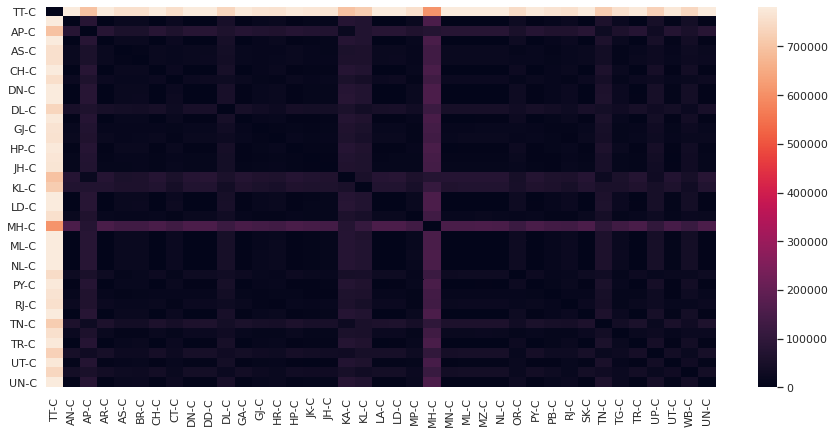

In [ ]:
sns.heatmap(scoreDs) #Without Normalisation

# Normalisation with population

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

In [ ]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)

    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()

    return Z

In [ ]:
states_map = {
    "Andaman and Nicobar Islands":"AN",
    "Andhra Pradesh":"AP",
    "Arunachal Pradesh":"AR",
    "Assam":"AS",
    "Bihar":"BR",
    "Chandigarh":"CH",
    "Chhattisgarh":"CT",
    "Dadra and Nagar Haveli and Daman and Diu":"DN",
    "Delhi":"DL",
    "Goa":"GA",
    "Gujarat":"GJ",
    "Haryana":"HR",
    "Himachal Pradesh":"HP",
    "Jammu and Kashmir":"JK",
    "Jharkhand":"JH",
    "Karnataka":"KA",
    "Kerala":"KL",
    "Ladakh":"LA",
    "Lakshadweep":"LD",
    "Madhya Pradesh":"MP",
    "Maharashtra":"MH",
    "Manipur":"MN",
    "Meghalaya":"ML",
    "Mizoram":"MZ",
    "Nagaland":"NL",
    "Odisha":"OR",
    "Puducherry":"PY",
    "Punjab":"PB",
    "Rajasthan":"RJ",
    "Sikkim":"SK",
    "Tamil Nadu":"TN",
    "Telangana":"TG",
    "Tripura":"TR",
    "Uttar Pradesh":"UP",
    "Uttarakhand":"UT",
    "West Bengal":"WB",
}

In [ ]:
population = {
    "AN": 380581,
    "AP": 49577103,
    "AR": 1383727,
    "AS": 31205576,
    "BR": 104099452,
    "CH": 1055450,
    "CT": 25545198,
    "DN": 585764,
    "DL": 16787941,
    "GA": 1458545,
    "GJ": 60439692,
    "HR": 25351462,
    "HP": 6864602,
    "JK": 12267032,
    "JH": 32988134,
    "KA": 61095297,
    "KL": 33406061,
    "LA": 274000,
    "LD": 64473,
    "MP": 72626809,
    "MH": 112374333,
    "MN": 2570390,
    "ML": 2966889,
    "MZ": 1097206,
    "NL": 1978502,
    "OR": 41974219,
    "PY": 1247953,
    "PB": 27743338,
    "RJ": 68548437,
    "SK": 610577,
    "TN": 72147030,
    "TG": 35003674,
    "TR": 3673917,
    "UP": 199812341,
    "UT": 10086292,
    "WB": 91276115,
    "TT": 1210569573
}

In [ ]:
len(population)

37

In [ ]:
len(states_map)

36

In [ ]:
len(current_ds.columns)

39

In [ ]:
print(list(filter( lambda x: x[:2] not in population, current_ds.columns)))


['DD-C', 'UN-C']


In [ ]:
normalised_ds=current_ds.drop(labels=['DD-C', 'UN-C'],axis=1)

In [ ]:
normalised_ds=normalised_ds.astype(float)

In [ ]:
normalised_ds.tail()

TT-C  AN-C   AP-C  AR-C  AS-C  ...   TG-C  TR-C    UP-C   UT-C   WB-C
Date                                          ...                                   
2021-01-07  18123.0   9.0  295.0   4.0  57.0  ...  379.0   8.0   503.0  249.0  921.0
2021-01-08  18453.0   1.0  319.0   7.0  50.0  ...  346.0   5.0   767.0  269.0  926.0
2021-01-09  18820.0   0.0  199.0   3.0  34.0  ...  298.0   0.0  1286.0  287.0  787.0
2021-01-10  16086.0   1.0  227.0   5.0  25.0  ...  351.0   8.0   275.0  223.0  823.0
2021-01-11  12481.0   3.0  121.0   5.0  45.0  ...  224.0   0.0   509.0  156.0  612.0

[5 rows x 37 columns]

In [ ]:
for j in normalised_ds.columns:
  val=population[j[:2]]
  for i in range(len(normalised_ds)):
    normalised_ds.iloc[i][j]/=val

In [ ]:
rev_states_map={}
cnt=0
for i in states_map:
  cnt+=1
  rev_states_map[states_map[i]]=(i,cnt)

In [ ]:
rev_states_map

{'AN': ('Andaman and Nicobar Islands', 1),
 'AP': ('Andhra Pradesh', 2),
 'AR': ('Arunachal Pradesh', 3),
 'AS': ('Assam', 4),
 'BR': ('Bihar', 5),
 'CH': ('Chandigarh', 6),
 'CT': ('Chhattisgarh', 7),
 'DL': ('Delhi', 9),
 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8),
 'GA': ('Goa', 10),
 'GJ': ('Gujarat', 11),
 'HP': ('Himachal Pradesh', 13),
 'HR': ('Haryana', 12),
 'JH': ('Jharkhand', 15),
 'JK': ('Jammu and Kashmir', 14),
 'KA': ('Karnataka', 16),
 'KL': ('Kerala', 17),
 'LA': ('Ladakh', 18),
 'LD': ('Lakshadweep', 19),
 'MH': ('Maharashtra', 21),
 'ML': ('Meghalaya', 23),
 'MN': ('Manipur', 22),
 'MP': ('Madhya Pradesh', 20),
 'MZ': ('Mizoram', 24),
 'NL': ('Nagaland', 25),
 'OR': ('Odisha', 26),
 'PB': ('Punjab', 28),
 'PY': ('Puducherry', 27),
 'RJ': ('Rajasthan', 29),
 'SK': ('Sikkim', 30),
 'TG': ('Telangana', 32),
 'TN': ('Tamil Nadu', 31),
 'TR': ('Tripura', 33),
 'UP': ('Uttar Pradesh', 34),
 'UT': ('Uttarakhand', 35),
 'WB': ('West Bengal', 36)}

1 Andaman and Nicobar Islands AN

2 Andhra Pradesh AP

3 Arunachal Pradesh AR

4 Assam AS

5 Bihar BR

6 Chandigarh CH

7 Chhattisgarh CT

8 Dadra and Nagar Haveli and Daman and Diu DN

9 Delhi DL

10 Goa GA

11 Gujarat GJ

12 Haryana HR

13 Himachal Pradesh HP

14 Jammu and Kashmir JK

15 Jharkhand JH

16 Karnataka KA

17 Kerala KL

18 Ladakh LA

19 Lakshadweep LD

20 Madhya Pradesh MP

21 Maharashtra MH

22 Manipur MN

23 Meghalaya ML

24 Mizoram MZ

25 Nagaland NL

26 Odisha OR

27 Puducherry PY

28 Punjab PB

29 Rajasthan RJ

30 Sikkim SK

31 Tamil Nadu TN

32 Telangana TG

33 Tripura TR

34 Uttar Pradesh UP

35 Uttarakhand UT

36 West Bengal WB

In [ ]:
scoreDs=getDTWScore(normalised_ds)

In [ ]:
scoreDs.index=scoreDs['Names']
scoreDs.drop(labels='Names',axis=1,inplace=True)

# Clustering

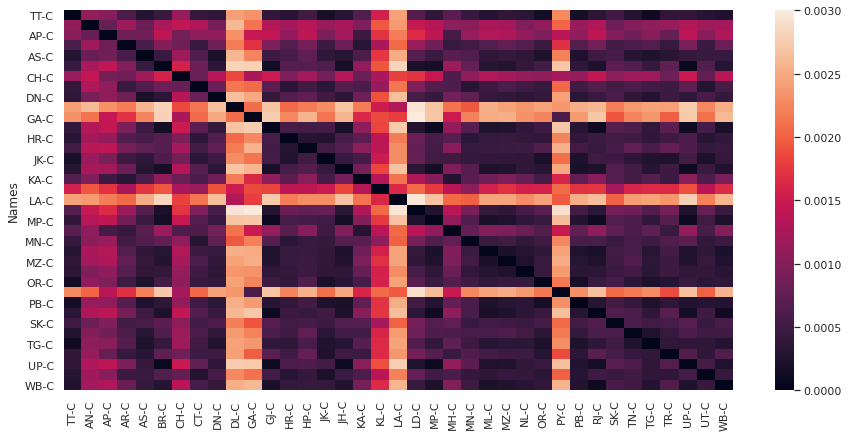

In [ ]:
sns.heatmap(scoreDs) #After Normalisation

In [ ]:
scoreDs.index.name=None
scoreDs

TT-C      AN-C      AP-C  ...      UP-C      UT-C      WB-C
TT-C  0.000000  0.001111  0.001031  ...  0.000383  0.000298  0.000254
AN-C  0.001111  0.000000  0.000793  ...  0.001293  0.001187  0.001224
AP-C  0.001031  0.000793  0.000000  ...  0.001386  0.001025  0.001303
AR-C  0.000593  0.001188  0.000834  ...  0.000932  0.000468  0.000818
AS-C  0.000282  0.000817  0.000874  ...  0.000421  0.000446  0.000432
BR-C  0.000450  0.001251  0.001413  ...  0.000087  0.000635  0.000295
CH-C  0.001134  0.001426  0.000890  ...  0.001486  0.000764  0.001374
CT-C  0.000416  0.001295  0.001082  ...  0.000744  0.000289  0.000563
DN-C  0.000372  0.000925  0.001085  ...  0.000372  0.000557  0.000417
DL-C  0.002416  0.002612  0.002322  ...  0.002754  0.002262  0.002525
GA-C  0.002329  0.002120  0.001454  ...  0.002744  0.002105  0.002607
GJ-C  0.000391  0.001320  0.001433  ...  0.000110  0.000541  0.000202
HR-C  0.000328  0.001221  0.001091  ...  0.000600  0.000305  0.000407
HP-C  0.000514  0.001358  0.001407  ...  0.000616  0.000416  0.000440
JK-C  0.000195  0.001156  0.000943  ...  0.000532  0.000222  0.000420
JH-C  0.000312  0.001247  0.001228  ...  0.000110  0.000469  0.000263
KA-C  0.000641  0.000970  0.000475  ...  0.001042  0.000606  0.000922
KL-C  0.001571  0.001959  0.001718  ...  0.001895  0.001375  0.001657
LA-C  0.002432  0.002386  0.002188  ...  0.002773  0.002209  0.002576
LD-C  0.000645  0.001474  0.001644  ...  0.000238  0.000776  0.000452
MP-C  0.000377  0.001334  0.001413  ...  0.000095  0.000509  0.000226
MH-C  0.000698  0.001068  0.000540  ...  0.001104  0.000580  0.000995
MN-C  0.000438  0.001049  0.001137  ...  0.000719  0.000405  0.000491
ML-C  0.000301  0.001269  0.001320  ...  0.000252  0.000374  0.000217
MZ-C  0.000381  0.001209  0.001304  ...  0.000264  0.000428  0.000267
NL-C  0.000344  0.000965  0.001097  ...  0.000392  0.000401  0.000318
OR-C  0.000145  0.001103  0.000960  ...  0.000447  0.000336  0.000385
PY-C  0.002274  0.002022  0.001369  ...  0.002657  0.002017  0.002560
PB-C  0.000171  0.001135  0.001091  ...  0.000280  0.000295  0.000287
RJ-C  0.000348  0.001310  0.001407  ...  0.000176  0.000495  0.000129
SK-C  0.000498  0.000823  0.000987  ...  0.000688  0.000453  0.000564
TN-C  0.000271  0.001005  0.000877  ...  0.000600  0.000504  0.000494
TG-C  0.000127  0.001078  0.001027  ...  0.000378  0.000381  0.000285
TR-C  0.000383  0.001138  0.000794  ...  0.000652  0.000379  0.000629
UP-C  0.000383  0.001293  0.001386  ...  0.000000  0.000549  0.000248
UT-C  0.000298  0.001187  0.001025  ...  0.000549  0.000000  0.000441
WB-C  0.000254  0.001224  0.001303  ...  0.000248  0.000441  0.000000

[37 rows x 37 columns]

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



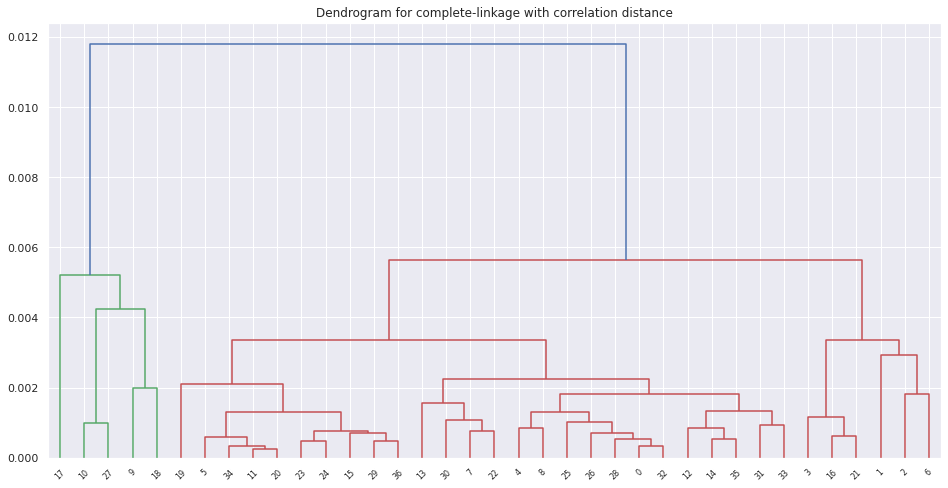

In [ ]:
linkage_matrix = hierarchical_clustering(scoreDs)

In [ ]:
new_array=[3, 4, 4, 4, 3, 2, 4, 3, 3, 1, 1, 2, 3, 3, 3, 2, 4, 1, 1, 2, 2, 4, 3, 2, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2]

[3, 4, 4, 4, 3, 2, 4, 3, 3, 1, 1, 2, 3, 3, 3, 2, 4, 1, 1, 2, 2, 4, 3, 2, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2]

In [ ]:
ind=[[0 for x in range(2)] for y in range(37)]
# print(ind)
for i in range(len(new_array)):
  ind[i][0]=i
  ind[i][1]=new_array[i]
  # print(str(i)+" "+str(new_array[i])+" "+str(ind[i]))
# print(ind)
print(sorted(ind,key=lambda x:x[1]))

[[9, 1], [10, 1], [17, 1], [18, 1], [27, 1], [5, 2], [11, 2], [15, 2], [19, 2], [20, 2], [23, 2], [24, 2], [29, 2], [34, 2], [36, 2], [0, 3], [4, 3], [7, 3], [8, 3], [12, 3], [13, 3], [14, 3], [22, 3], [25, 3], [26, 3], [28, 3], [30, 3], [31, 3], [32, 3], [33, 3], [35, 3], [1, 4], [2, 4], [3, 4], [6, 4], [16, 4], [21, 4]]


[[9, 1], [10, 1], [17, 1], [18, 1], [27, 1], [5, 2], [11, 2], [15, 2], [19, 2], [20, 2], [23, 2], [24, 2], [29, 2], [34, 2], [36, 2], [0, 3], [4, 3], [7, 3], [8, 3], [12, 3], [13, 3], [14, 3], [22, 3], [25, 3], [26, 3], [28, 3], [30, 3], [31, 3], [32, 3], [33, 3], [35, 3], [1, 4], [2, 4], [3, 4], [6, 4], [16, 4], [21, 4]]

In [ ]:
for i in rev_states_map:
  rev_states_map[i]=(rev_states_map[i][0],rev_states_map[i][1],new_array[rev_states_map[i][1]])
rev_states_map

{'AN': ('Andaman and Nicobar Islands', 1, 4),
 'AP': ('Andhra Pradesh', 2, 4),
 'AR': ('Arunachal Pradesh', 3, 4),
 'AS': ('Assam', 4, 3),
 'BR': ('Bihar', 5, 2),
 'CH': ('Chandigarh', 6, 4),
 'CT': ('Chhattisgarh', 7, 3),
 'DL': ('Delhi', 9, 1),
 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8, 3),
 'GA': ('Goa', 10, 1),
 'GJ': ('Gujarat', 11, 2),
 'HP': ('Himachal Pradesh', 13, 3),
 'HR': ('Haryana', 12, 3),
 'JH': ('Jharkhand', 15, 2),
 'JK': ('Jammu and Kashmir', 14, 3),
 'KA': ('Karnataka', 16, 4),
 'KL': ('Kerala', 17, 1),
 'LA': ('Ladakh', 18, 1),
 'LD': ('Lakshadweep', 19, 2),
 'MH': ('Maharashtra', 21, 4),
 'ML': ('Meghalaya', 23, 2),
 'MN': ('Manipur', 22, 3),
 'MP': ('Madhya Pradesh', 20, 2),
 'MZ': ('Mizoram', 24, 2),
 'NL': ('Nagaland', 25, 3),
 'OR': ('Odisha', 26, 3),
 'PB': ('Punjab', 28, 3),
 'PY': ('Puducherry', 27, 1),
 'RJ': ('Rajasthan', 29, 2),
 'SK': ('Sikkim', 30, 3),
 'TG': ('Telangana', 32, 3),
 'TN': ('Tamil Nadu', 31, 3),
 'TR': ('Tripura', 33, 3),
 'UP

{'AN': ('Andaman and Nicobar Islands', 1, 4)

 'AP': ('Andhra Pradesh', 2, 4)

 'AR': ('Arunachal Pradesh', 3, 4),

 'AS': ('Assam', 4, 3),

 'BR': ('Bihar', 5, 2),

 'CH': ('Chandigarh', 6, 4),

 'CT': ('Chhattisgarh', 7, 3),

 'DL': ('Delhi', 9, 1),

 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8, 3),

 'GA': ('Goa', 10, 1),

 'GJ': ('Gujarat', 11, 2),

 'HP': ('Himachal Pradesh', 13, 3),

 'HR': ('Haryana', 12, 3),

 'JH': ('Jharkhand', 15, 2),

 'JK': ('Jammu and Kashmir', 14, 3),

 'KA': ('Karnataka', 16, 4),

 'KL': ('Kerala', 17, 1),

 'LA': ('Ladakh', 18, 1),

 'LD': ('Lakshadweep', 19, 2),

 'MH': ('Maharashtra', 21, 4),

 'ML': ('Meghalaya', 23, 2),

 'MN': ('Manipur', 22, 3),

 'MP': ('Madhya Pradesh', 20, 2),

 'MZ': ('Mizoram', 24, 2),

 'NL': ('Nagaland', 25, 3),

 'OR': ('Odisha', 26, 3),

 'PB': ('Punjab', 28, 3),

 'PY': ('Puducherry', 27, 1),

 'RJ': ('Rajasthan', 29, 2),

 'SK': ('Sikkim', 30, 3),

 'TG': ('Telangana', 32, 3),

 'TN': ('Tamil Nadu', 31, 3),

 'TR': ('Tripura', 33, 3),

 'UP': ('Uttar Pradesh', 34, 2),

 'UT': ('Uttarakhand', 35, 3),

 'WB': ('West Bengal', 36, 2)}


# With Constrains of r=7

## Cluster 1 - 18,9,10,27

* Ladakh
* Delhi
* Goa
* Puducherry

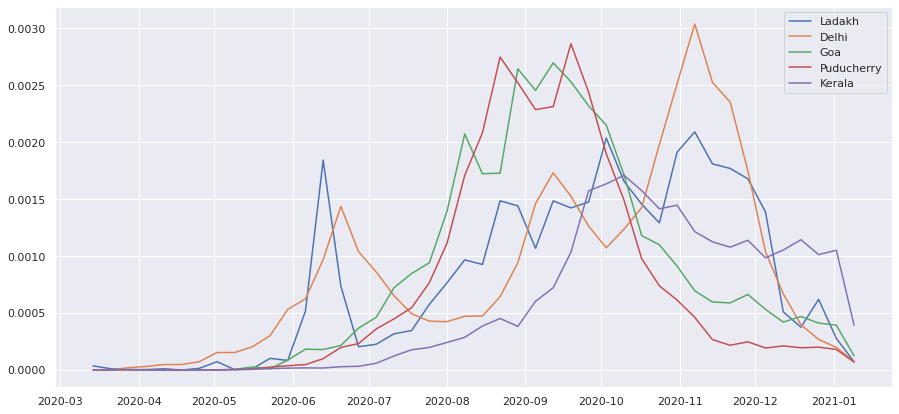

In [ ]:
plt.plot(normalised_ds["LA-C"].resample('7D').sum(),label="Ladakh")
plt.plot(normalised_ds["DL-C"].resample('7D').sum(),label="Delhi")
plt.plot(normalised_ds["GA-C"].resample('7D').sum(),label="Goa")
plt.plot(normalised_ds["PY-C"].resample('7D').sum(),label="Puducherry")
plt.plot(normalised_ds["KL-C"].resample('7D').sum(),label="Kerala")
plt.legend()

## Characteristics of Cluster 1


* Highly unreliable
* Random crests and troughs
* That's the reason we're getting states which apparently have nothing in common

## Who is the representative?

Delhi


## Cluster 2 - 17,30,...,6

* Kerala
* Sikkim
* Karanataka
* Arunachal Pradesh
* Mahrashtra
* Andhra Pradesh
* Andaman n Nicobar
* Chandigarh


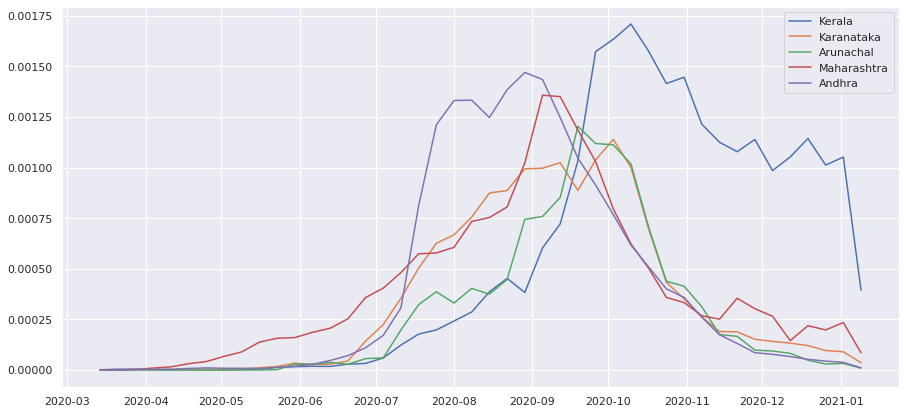

In [ ]:
plt.plot(normalised_ds["KL-C"].resample('7D').sum(),label="Kerala")
#plt.plot(normalised_ds["SK-C"],label="Sikkim")
#plt.plot(normalised_ds["MH-C"])
plt.plot(normalised_ds["KA-C"].resample('7D').sum(),label="Karanataka")
plt.plot(normalised_ds["AR-C"].resample('7D').sum(),label="Arunachal")
plt.plot(normalised_ds["MH-C"].resample('7D').sum(),label="Maharashtra")
plt.plot(normalised_ds["AP-C"].resample('7D').sum(),label="Andhra")
#plt.plot(normalised_ds["AN-C"],label="Andaman n Nicobar")
#plt.plot(normalised_ds["CH-C"].resample('7D'),label="Chandigrah")
plt.legend()



In [ ]:
normalised_ds.where(normalised_ds["MH-C"]<0).dropna()

TT-C      AN-C     AP-C  ...      UP-C      UT-C      WB-C
Date                                     ...                              
2020-12-16  0.000015  0.000021  0.00001  ...  0.000006  0.000056  0.000025

[1 rows x 37 columns]

In [ ]:
normalised_ds["MH-C"]["2020-12-16"]=5.26276761082088e-05

## Characteristics of Cluster 2


* The commented states showed anomalous shape as compared to the general shape of the cluster and thats the reason why it disappers from this cluster after r=7

* A sharp consistent rise to the peak at around mid-September and a similar sharp consistent decline by Jan 2021

* Might be considered the hostspot cluster

## Who is the representative?

Maharashtra


## Cluster 3 : 15,...,24

* Jharkahand
* Dadar n Nagar Haveli
* Punjab
* India
* Telangana
* Odisha
* Tamil Nadu
* Chhtaisgarh
* Manipur
* Tripura
* Uttrakhand
* Harayana
* Assam
* Himachal Pradesh
* J&K
* Nagaland
* Meghalya
* Mizoram


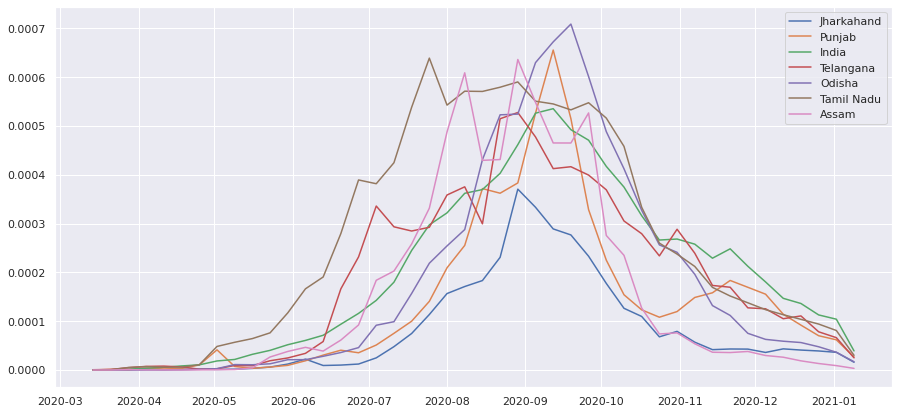

In [ ]:
plt.plot(normalised_ds["JH-C"].resample('7D').sum(),label="Jharkahand")
plt.plot(normalised_ds["PB-C"].resample('7D').sum(),label="Punjab")
plt.plot(normalised_ds["TT-C"].resample('7D').sum(),label="India")
plt.plot(normalised_ds["TG-C"].resample('7D').sum(),label="Telangana")
plt.plot(normalised_ds["OR-C"].resample('7D').sum(),label="Odisha")
plt.plot(normalised_ds["TN-C"].resample('7D').sum(),label="Tamil Nadu")
#plt.plot(normalised_ds["CT-C"],label="Chhtaisgarh")
#plt.plot(normalised_ds["UT-C"],label="Uttrakhand")
#plt.plot(normalised_ds["HR-C"],label="Harayana")
plt.plot(normalised_ds["AS-C"].resample('7D').sum(),label="Assam")
plt.legend()


## Characteristics of Cluster 3


* A not so steep rise to the peak (with some irregularities) and a similar gradual decline.

* Might be considered OK states and resembling the country in general

## Who is the representative?

India


## Cluster 4 - 19, ... , 36

* Lakswadeep
* Gujarat
* Bihar
* Uttar Pradesh
* Madhya Pradesh
* Rajasthan
* West Bengal


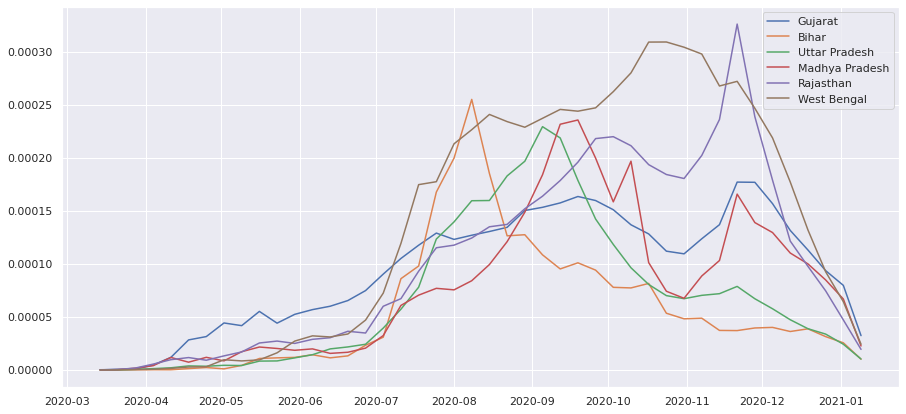

In [ ]:

#plt.plot(normalised_ds["LD-C"],label="Lakswadeep")
plt.plot(normalised_ds["GJ-C"].resample('7D').sum(),label="Gujarat")
plt.plot(normalised_ds["BR-C"].resample('7D').sum(),label="Bihar")
plt.plot(normalised_ds["UP-C"].resample('7D').sum(),label="Uttar Pradesh")
plt.plot(normalised_ds["MP-C"].resample('7D').sum(),label="Madhya Pradesh")
plt.plot(normalised_ds["RJ-C"].resample('7D').sum(),label="Rajasthan")
plt.plot(normalised_ds["WB-C"].resample('7D').sum(),label="West Bengal")

plt.legend()



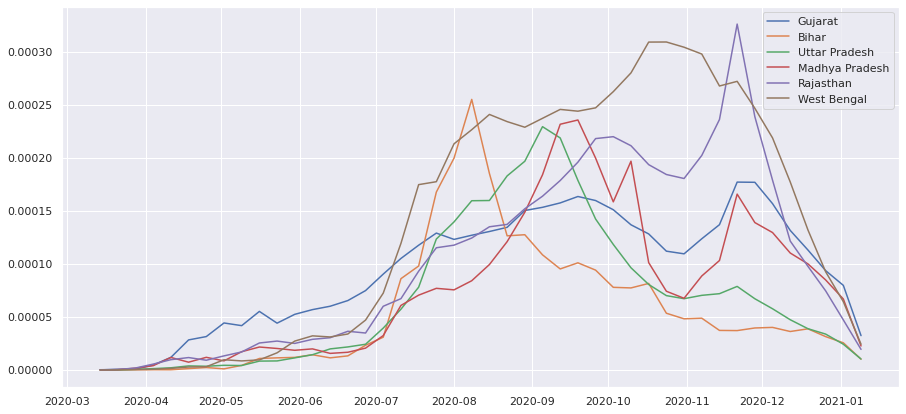

In [ ]:

#plt.plot(normalised_ds["LD-C"],label="Lakswadeep")
plt.plot(normalised_ds["GJ-C"].resample('7D').sum(),label="Gujarat")
plt.plot(normalised_ds["BR-C"].resample('7D').sum(),label="Bihar")
plt.plot(normalised_ds["UP-C"].resample('7D').sum(),label="Uttar Pradesh")
plt.plot(normalised_ds["MP-C"].resample('7D').sum(),label="Madhya Pradesh")
plt.plot(normalised_ds["RJ-C"].resample('7D').sum(),label="Rajasthan")
plt.plot(normalised_ds["WB-C"].resample('7D').sum(),label="West Bengal")

plt.legend()



## Characteristics of Cluster 4


* No visually sharp peak - a plateau like curve
* Represents the Hindi Heartland States
* Might be correlated with the regional festivals

## Who is the representative?

Madhya Pradesh



# Changes With Constraint of r = 7

## Cluster 1 - Unreliable

Everything remains same except an addition of new member - Kerala (17)

## Cluster 2 -  Sharp Rise n Decline

Everything remains same except that Kerala (17) and Sikkim(30) went out

## Cluster 3 - OK states - Moderate Rise n Decline

Everything remains same except that Jharkhand(15), Meghalaya(23) and Mizoram(24) went out and Sikkim(30) came in


## Cluster 4 - Plateau and Hindi States

Everything remains same except that Jharkhand(15), Meghalaya(23) and Mizoram(24) came in

# Inter Cluster Plot with one representation from each cluster

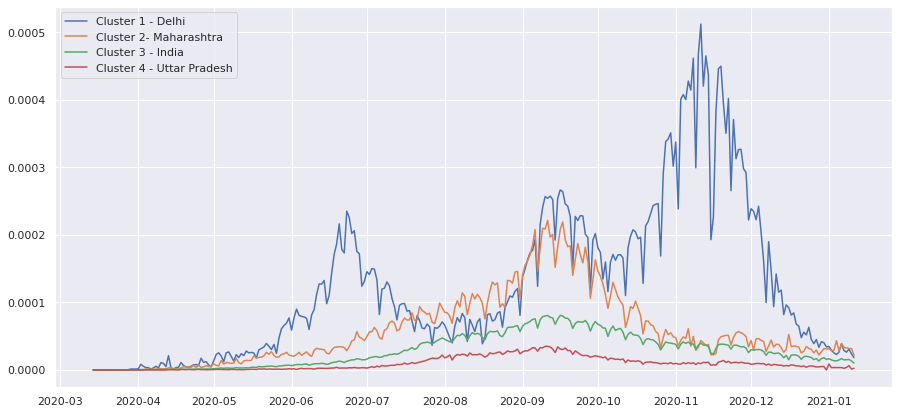

In [ ]:
plt.plot(normalised_ds["DL-C"],label="Cluster 1 - Delhi")
plt.plot(normalised_ds["MH-C"],label="Cluster 2- Maharashtra")
plt.plot(normalised_ds["TT-C"],label="Cluster 3 - India")
plt.plot(normalised_ds["UP-C"],label="Cluster 4 - Uttar Pradesh")
#plt.plot(normalised_ds["KL-C"],label="Kerala")
plt.legend()

In [ ]:
normalised_ds["MH-C"]

Date
2020-03-14    1.245836e-07
2020-03-15    1.601789e-07
2020-03-16    5.339298e-08
2020-03-17    2.669649e-08
2020-03-18    2.669649e-08
                  ...     
2021-01-07    3.318373e-05
2021-01-08    3.286338e-05
2021-01-09    3.186671e-05
2021-01-10    3.166203e-05
2021-01-11    2.169535e-05
Name: MH-C, Length: 304, dtype: float64

Next Meeting

1. District wise cluster graphs
2. Smoothen the curves - 7 days
3. Make r=7 as the primary
4. Colour India's map acc to the cluster

Stretch Goals

1. KMeans Clustering by putting k=3,4,5
2. Analysing deceased data

In [ ]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

In [ ]:
# import plotly.io as pio
# pio.renderers.default = 'browser'

In [ ]:
india_states = json.load(open("/content/drive/MyDrive/Covid19ClusterPrediction/states_india.geojson", "r"))

In [ ]:
state_id_map = {}
for feature in india_states["features"]:
    feature["id"] = feature["properties"]["state_code"]
    state_id_map[feature["properties"]["st_nm"]] = feature["id"]

In [ ]:
state_id_map

In [ ]:
len(state_id_map)

{'AN': ('Andaman and Nicobar Islands', 1, 4)

 'AP': ('Andhra Pradesh', 2, 4)

 'AR': ('Arunachal Pradesh', 3, 4),

 'AS': ('Assam', 4, 3),

 'BR': ('Bihar', 5, 2),

 'CH': ('Chandigarh', 6, 4),

 'CT': ('Chhattisgarh', 7, 3),

 'DL': ('Delhi', 9, 1),

 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8, 3),

 'GA': ('Goa', 10, 1),

 'GJ': ('Gujarat', 11, 2),

 'HP': ('Himachal Pradesh', 13, 3),

 'HR': ('Haryana', 12, 3),

 'JH': ('Jharkhand', 15, 2),

 'JK': ('Jammu and Kashmir', 14, 3),

 'KA': ('Karnataka', 16, 4),

 'KL': ('Kerala', 17, 1),

 'LA': ('Ladakh', 18, 1),

 'LD': ('Lakshadweep', 19, 2),

 'MH': ('Maharashtra', 21, 4),

 'ML': ('Meghalaya', 23, 2),

 'MN': ('Manipur', 22, 3),

 'MP': ('Madhya Pradesh', 20, 2),

 'MZ': ('Mizoram', 24, 2),

 'NL': ('Nagaland', 25, 3),

 'OR': ('Odisha', 26, 3),

 'PB': ('Punjab', 28, 3),

 'PY': ('Puducherry', 27, 1),

 'RJ': ('Rajasthan', 29, 2),

 'SK': ('Sikkim', 30, 3),

 'TG': ('Telangana', 32, 3),

 'TN': ('Tamil Nadu', 31, 3),

 'TR': ('Tripura', 33, 3),

 'UP': ('Uttar Pradesh', 34, 2),

 'UT': ('Uttarakhand', 35, 3),

 'WB': ('West Bengal', 36, 2)}


In [ ]:
state_name=[]
state_id=[]
state_cluster_id=[]

In [ ]:
temp=[]
cnt=0
for i in rev_states_map:
  if (rev_states_map[i][0] in state_id_map):
    # print(str(rev_states_map[i])+" "+str(state_id_map[rev_states_map[i][0]]))
    state_name.append(rev_states_map[i][0])
    state_id.append(state_id_map[rev_states_map[i][0]])
    state_cluster_id.append(rev_states_map[i][2])
  else:
    print(str(rev_states_map[i])+" NONE")
    state_name.append(rev_states_map[i][0])
    state_id.append(-1)
    state_cluster_id.append(rev_states_map[i][2])
    temp.append(cnt)
  cnt+=1

In [ ]:
print(temp)

In [ ]:
state_id[0]=35
state_id[2]=12
state_id[7]=26
state_id[8]=7
state_id[13]=1

In [ ]:
del(state_name[17])
del(state_cluster_id[17])
del(state_id[17])

In [ ]:
for i in range(len(state_cluster_id)):
  print(str(state_name[i])+" "+str(state_id[i])+" "+str(state_cluster_id[i]))

In [ ]:
lis=[0,1,5,2,4,8]
del(lis[2])
print(lis)

In [ ]:
len(rev_states_map)

In [ ]:
coldf=pd.DataFrame(data={"Name": state_name, "State Code":state_id, "State Cluster Number":state_cluster_id})

In [ ]:
coldf.head()

In [ ]:
fig = px.choropleth_mapbox(
    coldf,
    locations="State Code",
    geojson=india_states,
    color="State Cluster Number",
    hover_name="State Cluster Number",
    hover_data=["State Cluster Number"],
    mapbox_style="carto-positron",
    center={"lat": 24, "lon": 78},
    zoom=3,
    opacity=0.5,
)
# fig.update_geos(fitbounds="locations", visible=False)/
fig.show()

In [ ]:
cluster1=[21,251,210,328,134,396,617,618,635,243,626,246,321]
cluster2=[166,25,391,314,223,488,163,468,15,88,219,77,218,225,24,357,72,156,371,217,495,170,214,611,216,326,442,145,178,92,187,71,385,174,175,643,139,583,374,376,13,179,165,80,482,393,341,380,490,140,480,215,390,129,411,334,201,307,319,641,456,494,578,489,309,157,325,146,478,630,231,365,79,135,581,392,213,440,73,147,525,65,486,160,311,584,615,226,233,360,23,340,330,306,375,388,336,370,221,312,462,479,333,621,406,426,622,149,94,368,22,176,181,350,600,4,639,90,620,235,473,270,399,69,400,408,151,492,460,222,634,228,313,638,574,173,206]

In [ ]:
cluster2.index(206)

In [ ]:
breakpoints=[321,206,441,234,324,454]

In [ ]:
index=[-1]
for i in range(len(breakpoints)):
  index.append(labels.index(breakpoints[i]))

In [ ]:
clusters=[]
for i in range(len(index)):
  clusters.append(labels[index[i-1]+1:index[i]+1])

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 4.8MB/s 
     |████████████████████████████████| 6.5MB 13.1MB/s 
     |████████████████████████████████| 14.8MB 239kB/s 


In [ ]:
import geopandas as gpd

In [ ]:
district_map_df = gpd.read_file('/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/c44c9b96-f570-4ee3-97f1-ebad64efa4c2202044-1-1rb4x6s.8xx6.shp')
district_map_df.head()

objectid  ...                                           geometry
0         1  ...  POLYGON ((75.23335 21.41481, 75.23469 21.41453...
1         2  ...  POLYGON ((74.13013 20.86311, 74.13215 20.86160...
2         3  ...  POLYGON ((79.75755 20.73462, 79.76047 20.73463...
3         4  ...  POLYGON ((78.26132 20.69735, 78.26276 20.69717...
4         5  ...  POLYGON ((78.05387 19.92452, 78.05449 19.92435...

[5 rows x 10 columns]

In [ ]:
len(district_map_df)

727

In [ ]:
district_map_df["distname"].iloc[417]="Raigad"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
district_map_df[district_map_df['distname']=="Raigad"]

objectid  ...                                           geometry
417       418  ...  POLYGON ((73.52538 19.12940, 73.52496 19.12858...

[1 rows x 10 columns]

In [ ]:
state_map_df=gpd.read_file('/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/india-polygon.shp')
state_map_df.tail()

id              st_nm                                           geometry
32  None        West Bengal  MULTIPOLYGON (((88.22156 21.76255, 88.31155 21...
33  None             Odisha  POLYGON ((86.72769 22.21848, 86.72094 22.14704...
34  None     Andhra Pradesh  POLYGON ((81.10545 17.82313, 81.39342 17.81473...
35  None  Jammu and Kashmir  POLYGON ((74.09957 35.14187, 74.52028 35.10615...
36  None             Ladakh  POLYGON ((76.79483 33.25515, 76.39662 33.66695...

In [ ]:
len(state_map_df)

37

In [ ]:
merged_df=district_map_df[["distname",'geometry']].copy().rename(columns={"distname": "name"})\
.append((state_map_df[["st_nm","geometry"]].copy().rename(columns={"st_nm":"name"})),ignore_index=True)
# merged_df["goemetry"]=district_map_df['geometry']
# merged_df.head()

In [ ]:
len(merged_df)

764

In [ ]:
import random

In [ ]:
cluster_code=[]
for i in range(len(merged_df)):
  cluster_code.append(random.randint(1,4))
print(cluster_code)

[2, 3, 4, 4, 2, 2, 4, 3, 3, 3, 4, 2, 1, 3, 2, 2, 4, 3, 2, 2, 2, 4, 4, 3, 4, 1, 3, 4, 1, 3, 3, 4, 4, 4, 1, 1, 3, 2, 3, 1, 3, 3, 1, 2, 2, 1, 2, 4, 3, 2, 4, 3, 3, 4, 1, 1, 4, 2, 4, 4, 3, 2, 4, 3, 3, 3, 1, 1, 3, 2, 4, 1, 1, 2, 2, 3, 2, 4, 3, 2, 4, 2, 4, 4, 3, 2, 4, 4, 2, 2, 4, 3, 2, 2, 3, 4, 4, 2, 3, 4, 1, 2, 1, 4, 4, 1, 1, 1, 3, 3, 1, 2, 2, 1, 1, 3, 1, 4, 3, 3, 2, 2, 1, 1, 1, 2, 4, 4, 3, 3, 1, 2, 3, 4, 1, 3, 1, 3, 2, 4, 2, 3, 3, 2, 2, 4, 3, 1, 1, 2, 3, 2, 4, 1, 1, 2, 4, 1, 2, 4, 4, 4, 2, 3, 4, 2, 1, 1, 4, 1, 2, 2, 3, 4, 4, 3, 2, 3, 2, 3, 2, 1, 1, 2, 2, 3, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 4, 1, 4, 3, 1, 2, 4, 2, 1, 4, 2, 4, 4, 2, 4, 4, 1, 3, 1, 3, 3, 4, 4, 3, 4, 4, 2, 1, 3, 3, 2, 4, 4, 1, 1, 3, 4, 4, 4, 1, 3, 1, 1, 3, 4, 1, 3, 1, 3, 2, 4, 4, 4, 3, 1, 1, 1, 4, 2, 4, 3, 2, 4, 2, 2, 4, 1, 1, 4, 4, 1, 1, 3, 2, 1, 4, 1, 1, 3, 1, 2, 4, 1, 1, 4, 4, 1, 2, 3, 2, 3, 3, 4, 3, 3, 2, 4, 3, 2, 2, 2, 4, 2, 2, 3, 1, 2, 2, 2, 2, 3, 4, 2, 4, 3, 3, 2, 4, 4, 4, 2, 4, 3, 1, 1, 1, 3, 1, 3, 3, 2, 4, 2, 2, 3, 1, 2, 

In [ ]:
merged_df["Cluster_Code"]=cluster_code
merged_df.head()

name                                           geometry  Cluster_Code
0     Jalgaon  POLYGON ((75.23335 21.41481, 75.23469 21.41453...             2
1      Nashik  POLYGON ((74.13013 20.86311, 74.13215 20.86160...             3
2  Chandrapur  POLYGON ((79.75755 20.73462, 79.76047 20.73463...             4
3    Yavatmal  POLYGON ((78.26132 20.69735, 78.26276 20.69717...             4
4      Nanded  POLYGON ((78.05387 19.92452, 78.05449 19.92435...             2

In [ ]:
merged_df=merged_df.iloc[::-1]

In [ ]:
# type(merged_df)

geopandas.geodataframe.GeoDataFrame

In [ ]:
# final_df=merged_df.iloc[:37]

In [ ]:
# final_df.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/final_map_2.0.csv",index=False)

Load From Here

In [ ]:
# read_df=pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/final_map.csv")
# read_df.set_index("Unnamed: 0",inplace=True)
# read_df.index.name = None
# read_df.head()

name  ... Cluster_Code
763             Ladakh  ...            1
762  Jammu and Kashmir  ...            3
761     Andhra Pradesh  ...            4
760             Odisha  ...            3
759        West Bengal  ...            2

[5 rows x 3 columns]

In [ ]:
# map=dict({})
# for i in range(len(read_df)):
#   map[read_df["name"].iloc[i]]=read_df["Cluster_Code"].iloc[i]
# print(map)

{'Ladakh': 1, 'Jammu and Kashmir': 3, 'Andhra Pradesh': 4, 'Odisha': 3, 'West Bengal': 2, 'Uttarakhand': 3, 'Uttar Pradesh': 2, 'Tripura': 3, 'Telangana': 3, 'Tamil Nadu': 3, 'Sikkim': 3, 'Rajasthan': 2, 'Punjab': 3, 'Puducherry': 1, 'Delhi': 1, 'Nagaland': 3, 'Mizoram': 2, 'Meghalaya': 2, 'Manipur': 3, 'Maharashtra': 4, 'Madhya Pradesh': 2, 'Lakshadweep': 2, 'Kerala': 1, 'Karnataka': 4, 'Jharkhand': 2, 'Himachal Pradesh': 3, 'Haryana': 3, 'Gujarat': 2, 'Goa': 1, 'Daman and Diu': 3, 'Dadra and Nagar Haveli': 3, 'Chhattisgarh': 3, 'Chandigarh': 4, 'Bihar': 2, 'Assam': 3, 'Arunachal Pradesh': 4, 'Andaman and Nicobar Islands': 4}


In [ ]:
# for i in range(len(final_df)):
#   final_df["Cluster_Code"].iloc[i]=map[final_df["name"].iloc[i]]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# type(final_df)

geopandas.geodataframe.GeoDataFrame

In [ ]:
# final_df=final_df[::-1]
# final_df

In [ ]:
# final_df.to_file("/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/final_map.shp")

----------------------------------------------------------------------------

Only States

Load Here


In [ ]:
read_df=gpd.read_file("/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/final_map.shp")
read_df.rename(columns=({"Cluster_Co":"Cluster_Code"}),inplace=True)
read_df

name  ...                                           geometry
0   Andaman and Nicobar Islands  ...  MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...
1             Arunachal Pradesh  ...  POLYGON ((95.23643 26.68105, 95.19594 27.03612...
2                         Assam  ...  POLYGON ((95.19594 27.03612, 95.08795 26.94578...
3                         Bihar  ...  POLYGON ((88.11357 26.54028, 88.28006 26.37640...
4                    Chandigarh  ...  POLYGON ((76.84208 30.76124, 76.83758 30.72552...
5                  Chhattisgarh  ...  POLYGON ((83.94694 23.62196, 83.95594 23.62406...
6        Dadra and Nagar Haveli  ...  POLYGON ((73.20640 20.12165, 73.20865 20.10695...
7                 Daman and Diu  ...  POLYGON ((72.80144 20.37378, 72.84418 20.47463...
8                           Goa  ...  POLYGON ((74.11982 15.65278, 74.24806 15.65698...
9                       Gujarat  ...  MULTIPOLYGON (((68.35808 23.80475, 68.41658 23...
10                      Haryana  ...  POLYGON ((77.12555 30.56374, 77.21329 30.50281...
11             Himachal Pradesh  ...  POLYGON ((78.92089 31.25498, 79.01313 31.11211...
12                    Jharkhand  ...  POLYGON ((87.79410 25.22084, 87.77835 25.10108...
13                    Karnataka  ...  POLYGON ((77.55301 18.29376, 77.65650 17.97231...
14                       Kerala  ...  POLYGON ((76.43261 11.66713, 76.23238 11.57049...
15                  Lakshadweep  ...  MULTIPOLYGON (((74.10182 11.20491, 73.96458 11...
16               Madhya Pradesh  ...  POLYGON ((82.81529 23.96232, 82.55207 23.79214...
17                  Maharashtra  ...  POLYGON ((80.66449 21.33184, 80.64649 21.25411...
18                      Manipur  ...  POLYGON ((94.68073 25.45405, 94.59974 25.18932...
19                    Meghalaya  ...  POLYGON ((92.43993 25.03175, 92.07772 25.18512...
20                      Mizoram  ...  POLYGON ((93.00013 24.39934, 92.98439 24.12620...
21                     Nagaland  ...  POLYGON ((95.23643 26.68105, 95.06770 26.46044...
22                        Delhi  ...  POLYGON ((77.19755 28.86191, 77.33703 28.67912...
23                   Puducherry  ...  MULTIPOLYGON (((79.79156 10.99271, 79.79156 10...
24                       Punjab  ...  POLYGON ((76.73859 30.93982, 76.73859 30.93562...
25                    Rajasthan  ...  POLYGON ((74.28855 29.95655, 74.29980 29.95655...
26                       Sikkim  ...  POLYGON ((88.75926 27.14748, 88.59728 27.19370...
27                   Tamil Nadu  ...  MULTIPOLYGON (((79.78256 11.89825, 79.79156 11...
28                    Telangana  ...  POLYGON ((81.05595 17.79162, 81.05820 17.75380...
29                      Tripura  ...  POLYGON ((92.23295 24.50229, 92.27345 24.38673...
30                Uttar Pradesh  ...  POLYGON ((80.07054 28.82830, 80.37201 28.63290...
31                  Uttarakhand  ...  POLYGON ((80.07054 28.82830, 80.00079 28.71064...
32                  West Bengal  ...  MULTIPOLYGON (((88.22156 21.76255, 88.31155 21...
33                       Odisha  ...  POLYGON ((86.72769 22.21848, 86.72094 22.14704...
34               Andhra Pradesh  ...  POLYGON ((81.10545 17.82313, 81.39342 17.81473...
35            Jammu and Kashmir  ...  POLYGON ((74.09957 35.14187, 74.52028 35.10615...
36                       Ladakh  ...  POLYGON ((76.79483 33.25515, 76.39662 33.66695...

[37 rows x 3 columns]

In [ ]:
read_df["Cluster_Code"].iloc[36]=4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4

In [ ]:
read_df[read_df['name']=="Ladakh"]

name  Cluster_Code                                           geometry
36  Ladakh             4  POLYGON ((76.79483 33.25515, 76.39662 33.66695...

----------------------------------------------------------------------------------

------------------------------------------------------------------------------------

For Adding Districts

In [ ]:
# district_to_include=set({"Pune","Gurugram","Nagpur","Bengaluru Rural","Kozhikode","Nashik","Thane","Visakhapatnam","Indore","Coimbatore","Shimla","Palakkad","Lucknow","Raipur","Mumbai","Dehradun","Raigarh","Kolhapur","Srinagar","Jammu","Chennai","Faridabad","Kurnool","Raigad","Kolkata","Ernakulam","Thiruvananthapuram"})

In [ ]:
# district_to_include=set({" Papum Pare"," Pune"," Puducherry"," Leh"," Gurugram"," Nagpur"," Bengaluru Urban"," Kozhikode"," Pathanamthitta"," Faridabad"," Bijapur"," Kinnaur"," Raigad"," Sangli"," Kottayam"," Delhi"," Khordha"," Alappuzha"," S.P.S. Nellore"," Karaikal"," Thrissur"," Ernakulam"," East Godavari"," Kancheepuram"," Prakasam"})

In [ ]:
# district_to_include=set({" Puri"," Rajnandgaon"," Bagalkote"," Rewari"," Udhampur"," Raichur"," Rayagada"," Jagatsinghpur"," Gomati"," Surajpur"," Uttarkashi"," Nainital"," Krishna"," Davanagere"," Janjgir Champa"," Budgam"," Uttar Bastar Kanker"," Gadchiroli"," Solapur"," Tirap"," Amravati"," Balod"," Malkangiri"," Rudraprayag"," Sonipat"," Karnal"," Bhopal"," Peren"," Kullu"," Chamoli"," Boudh"," Cuttack"," Tirunelveli"," Changlang"," Solan"," Aurangabad"," Jodhpur"," Kurukshetra"," Kanyakumari"," North Tripura"," West Kameng"," Chandrapur"," Uttara Kannada"," Bilaspur"," Virudhunagar"," West Siang"," Thiruvarur"," Faridkot"," Dakshin Bastar Dantewada"," Kallakurichi"," Aizawl"," Dhalai"," Thiruvallur"," Palghar"," East Siang"," Latur"," Bastar"," Daman"," Nayagarh"," Kishtwar"," Pathankot"," Ramban"," Samba"," Unokoti"," Tumakuru"," Bathinda"," Udham Singh Nagar"," Kalaburagi"," Gondia"," Rajouri"," Bhandara"," Ludhiana"," Ranchi"," Panipat"," North 24 Parganas"," Kabeerdham"," Wardha"," Salem"," Dharwad"," Punch"," Gwalior"," Thoothukkudi"," Bilaspur"," East Jaintia Hills"," Dhamtari"," Dhule"," Osmanabad"," Pulwama"," Mandi"," Ratnagiri"," Nilgiris"," Vellore"," Kondagaon"," Ambala"," Gajapati"," Shopiyan"," Kohima"," East Singhbhum"," Subarnapur"," Bandipora"," Ganjam"," Angul"," Koppal"," Sambalpur"," Gadag"," Doda"," Jalandhar"," Kandhamal"," Cuddalore"," South Tripura"," Gautam Buddha Nagar"," East Khasi Hills"," Sindhudurg"," Chitradurga"," Upper Subansiri"," Haveri"," Rohtak"," Chikkaballapura"," Chikkamagaluru"," Kota"," Hisar"," Mandya"," Bargarh"," Kodagu"," Bikaner"," Yadgir"," Nashik"," Narayanpur"," Kannur"," Kasaragod"," Sukma"," Thane"," Visakhapatnam"," Indore"," Ganderbal"," Shivamogga"," Jammu"," Kargil"," Mysuru"," Anantapur"," Coimbatore"," Shimla"," Palakkad"," Idukki"," Jharsuguda"," Theni"," Dakshina Kannada"," Ballari"," Lucknow"," Raipur"," Mumbai"," Dehradun"," Guntur"," West Tripura"," Jalgaon"," Surguja"," Nuapada"," Raigarh"," Dimapur"," Kolhapur"," Ahmednagar"," Srinagar"," Panchkula"," Chengalpattu"," Hassan"," Korba"," Ranipet"," Chennai"," Malappuram"," S.A.S. Nagar"," Chandigarh"," Kurnool"," Srikakulam"," Wayanad"," Kolkata"," Kollam"," Chittoor"," Bengaluru Rural"," Y.S.R. Kadapa"," Satara"," Vizianagaram"," Udupi"," Bametara"," Thiruvananthapuram"," West Godavari"})

In [ ]:
district_to_include=set({" Pune"," Puducherry"," Gurugram"," Nagpur"," Bengaluru Rural"," Kozhikode"," Pathanamthitta"," Faridabad"," Bijapur"," Raigad"," Sangli"," Kottayam"," Delhi"," Khordha"," Alappuzha"," Sri Potti Sriramulu Nell*"," Thrissur"," Ernakulam"," East Godavari"," Kancheepuram"," Prakasam"})

In [ ]:
for d in district_to_include:
  district_to_include.remove(d)
  district_to_include.add(d.strip())
print(district_to_include)

{'Faridabad', 'Alappuzha', 'Thrissur', 'Raigad', 'Kottayam', 'Delhi', 'Sangli', 'Pune', 'Ernakulam', 'Bengaluru Rural', 'Pathanamthitta', 'Nagpur', 'Kancheepuram', 'Prakasam', 'Sri Potti Sriramulu Nell*', 'East Godavari', 'Bijapur', 'Khordha', 'Puducherry', 'Gurugram', 'Kozhikode'}


In [ ]:
len(district_to_include)

21

In [ ]:
vis=set({})
temp_df=pd.DataFrame(columns=merged_df.columns)
for i in range(len(merged_df)):
  if (merged_df.iloc[i]['name'] in district_to_include):
    temp_df=temp_df.append(merged_df.iloc[i],ignore_index=True)
    vis.add(merged_df.iloc[i]['name'])
# merged_df[merged_df["name"] in district_to_include]

In [ ]:
district_to_include.difference(vis)

set()

In [ ]:
len(district_to_include.difference(vis))

0

In [ ]:
len(temp_df)

22

In [ ]:
len(temp_df["name"].unique())

21

In [ ]:
# temp_df=temp_df.iloc[1:]

In [ ]:
temp_df["Cluster_Code"]=[1 for x in range(len(temp_df))]

In [ ]:
temp_df

name  ... Cluster_Code
0                  Puducherry  ...            1
1                       Delhi  ...            1
2                     Bijapur  ...            1
3                      Raigad  ...            1
4                      Nagpur  ...            1
5                  Puducherry  ...            1
6                   Faridabad  ...            1
7                    Gurugram  ...            1
8                     Khordha  ...            1
9              Pathanamthitta  ...            1
10                   Kottayam  ...            1
11                  Alappuzha  ...            1
12                  Ernakulam  ...            1
13                   Thrissur  ...            1
14                  Kozhikode  ...            1
15               Kancheepuram  ...            1
16            Bengaluru Rural  ...            1
17  Sri Potti Sriramulu Nell*  ...            1
18                   Prakasam  ...            1
19              East Godavari  ...            1
20                     Sangli  ...            1
21                       Pune  ...            1

[22 rows x 3 columns]

In [ ]:
# pset=set({"Pune","Gurugram","Nagpur","Kozhikode"})

In [ ]:
# for i in range(len(temp_df)):
#   if (temp_df["name"].iloc[i] in pset):
#     # print(temp_df["Cluster_Code"].iloc[i])
#     temp_df["Cluster_Code"].iloc[i]=1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
final_df=read_df.append(temp_df,ignore_index=True)

In [ ]:
final_df

name  ...                                           geometry
0   Andaman and Nicobar Islands  ...  MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...
1             Arunachal Pradesh  ...  POLYGON ((95.23643 26.68105, 95.19594 27.03612...
2                         Assam  ...  POLYGON ((95.19594 27.03612, 95.08795 26.94578...
3                         Bihar  ...  POLYGON ((88.11357 26.54028, 88.28006 26.37640...
4                    Chandigarh  ...  POLYGON ((76.84208 30.76124, 76.83758 30.72552...
5                  Chhattisgarh  ...  POLYGON ((83.94694 23.62196, 83.95594 23.62406...
6        Dadra and Nagar Haveli  ...  POLYGON ((73.20640 20.12165, 73.20865 20.10695...
7                 Daman and Diu  ...  POLYGON ((72.80144 20.37378, 72.84418 20.47463...
8                           Goa  ...  POLYGON ((74.11982 15.65278, 74.24806 15.65698...
9                       Gujarat  ...  MULTIPOLYGON (((68.35808 23.80475, 68.41658 23...
10                      Haryana  ...  POLYGON ((77.12555 30.56374, 77.21329 30.50281...
11             Himachal Pradesh  ...  POLYGON ((78.92089 31.25498, 79.01313 31.11211...
12                    Jharkhand  ...  POLYGON ((87.79410 25.22084, 87.77835 25.10108...
13                    Karnataka  ...  POLYGON ((77.55301 18.29376, 77.65650 17.97231...
14                       Kerala  ...  POLYGON ((76.43261 11.66713, 76.23238 11.57049...
15                  Lakshadweep  ...  MULTIPOLYGON (((74.10182 11.20491, 73.96458 11...
16               Madhya Pradesh  ...  POLYGON ((82.81529 23.96232, 82.55207 23.79214...
17                  Maharashtra  ...  POLYGON ((80.66449 21.33184, 80.64649 21.25411...
18                      Manipur  ...  POLYGON ((94.68073 25.45405, 94.59974 25.18932...
19                    Meghalaya  ...  POLYGON ((92.43993 25.03175, 92.07772 25.18512...
20                      Mizoram  ...  POLYGON ((93.00013 24.39934, 92.98439 24.12620...
21                     Nagaland  ...  POLYGON ((95.23643 26.68105, 95.06770 26.46044...
22                        Delhi  ...  POLYGON ((77.19755 28.86191, 77.33703 28.67912...
23                   Puducherry  ...  MULTIPOLYGON (((79.79156 10.99271, 79.79156 10...
24                       Punjab  ...  POLYGON ((76.73859 30.93982, 76.73859 30.93562...
25                    Rajasthan  ...  POLYGON ((74.28855 29.95655, 74.29980 29.95655...
26                       Sikkim  ...  POLYGON ((88.75926 27.14748, 88.59728 27.19370...
27                   Tamil Nadu  ...  MULTIPOLYGON (((79.78256 11.89825, 79.79156 11...
28                    Telangana  ...  POLYGON ((81.05595 17.79162, 81.05820 17.75380...
29                      Tripura  ...  POLYGON ((92.23295 24.50229, 92.27345 24.38673...
30                Uttar Pradesh  ...  POLYGON ((80.07054 28.82830, 80.37201 28.63290...
31                  Uttarakhand  ...  POLYGON ((80.07054 28.82830, 80.00079 28.71064...
32                  West Bengal  ...  MULTIPOLYGON (((88.22156 21.76255, 88.31155 21...
33                       Odisha  ...  POLYGON ((86.72769 22.21848, 86.72094 22.14704...
34               Andhra Pradesh  ...  POLYGON ((81.10545 17.82313, 81.39342 17.81473...
35            Jammu and Kashmir  ...  POLYGON ((74.09957 35.14187, 74.52028 35.10615...
36                       Ladakh  ...  POLYGON ((76.79483 33.25515, 76.39662 33.66695...
37                   Puducherry  ...  MULTIPOLYGON (((79.79156 10.99271, 79.79156 10...
38                        Delhi  ...  POLYGON ((77.19755 28.86191, 77.33703 28.67912...
39                      Bijapur  ...  POLYGON ((80.59530 19.34397, 80.59609 19.34218...
40                       Raigad  ...  POLYGON ((73.52538 19.12940, 73.52496 19.12858...
41                       Nagpur  ...  POLYGON ((79.23178 21.72221, 79.23235 21.72213...
42                   Puducherry  ...  MULTIPOLYGON (((79.75542 12.00440, 79.75706 12...
43                    Faridabad  ...  POLYGON ((77.34543 28.51323, 77.34556 28.51296...
44                     Gurugram  ...  POLYGON ((77.00726 28.54118, 

In [ ]:
# final_df.to_file("/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/final_map_2.0.csv")

After Adding Handpicked Districts

In [ ]:
# read_df=gpd.read_file("/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/final_map_2.0.csv")
# read_df.rename(columns={"Cluster_Co":"Cluster_Code"},inplace=True)
# read_df

name  ...                                           geometry
0   Andaman and Nicobar Islands  ...  MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...
1             Arunachal Pradesh  ...  POLYGON ((95.23643 26.68105, 95.19594 27.03612...
2                         Assam  ...  POLYGON ((95.19594 27.03612, 95.08795 26.94578...
3                         Bihar  ...  POLYGON ((88.11357 26.54028, 88.28006 26.37640...
4                    Chandigarh  ...  POLYGON ((76.84208 30.76124, 76.83758 30.72552...
..                          ...  ...                                                ...
59              Bengaluru Rural  ...  POLYGON ((77.38565 13.49861, 77.38636 13.49830...
60                      Kurnool  ...  POLYGON ((78.85472 16.14884, 78.85668 16.14859...
61                Visakhapatnam  ...  POLYGON ((82.48649 18.55033, 82.48728 18.55006...
62                         Pune  ...  POLYGON ((73.80569 19.39415, 73.80694 19.39350...
63                       Nashik  ...  POLYGON ((74.13013 20.86311, 74.13215 20.86160...

[64 rows x 3 columns]

In [ ]:
merged_df=final_df

In [ ]:
merged_df

name  ...                                           geometry
0   Andaman and Nicobar Islands  ...  MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...
1             Arunachal Pradesh  ...  POLYGON ((95.23643 26.68105, 95.19594 27.03612...
2                         Assam  ...  POLYGON ((95.19594 27.03612, 95.08795 26.94578...
3                         Bihar  ...  POLYGON ((88.11357 26.54028, 88.28006 26.37640...
4                    Chandigarh  ...  POLYGON ((76.84208 30.76124, 76.83758 30.72552...
5                  Chhattisgarh  ...  POLYGON ((83.94694 23.62196, 83.95594 23.62406...
6        Dadra and Nagar Haveli  ...  POLYGON ((73.20640 20.12165, 73.20865 20.10695...
7                 Daman and Diu  ...  POLYGON ((72.80144 20.37378, 72.84418 20.47463...
8                           Goa  ...  POLYGON ((74.11982 15.65278, 74.24806 15.65698...
9                       Gujarat  ...  MULTIPOLYGON (((68.35808 23.80475, 68.41658 23...
10                      Haryana  ...  POLYGON ((77.12555 30.56374, 77.21329 30.50281...
11             Himachal Pradesh  ...  POLYGON ((78.92089 31.25498, 79.01313 31.11211...
12                    Jharkhand  ...  POLYGON ((87.79410 25.22084, 87.77835 25.10108...
13                    Karnataka  ...  POLYGON ((77.55301 18.29376, 77.65650 17.97231...
14                       Kerala  ...  POLYGON ((76.43261 11.66713, 76.23238 11.57049...
15                  Lakshadweep  ...  MULTIPOLYGON (((74.10182 11.20491, 73.96458 11...
16               Madhya Pradesh  ...  POLYGON ((82.81529 23.96232, 82.55207 23.79214...
17                  Maharashtra  ...  POLYGON ((80.66449 21.33184, 80.64649 21.25411...
18                      Manipur  ...  POLYGON ((94.68073 25.45405, 94.59974 25.18932...
19                    Meghalaya  ...  POLYGON ((92.43993 25.03175, 92.07772 25.18512...
20                      Mizoram  ...  POLYGON ((93.00013 24.39934, 92.98439 24.12620...
21                     Nagaland  ...  POLYGON ((95.23643 26.68105, 95.06770 26.46044...
22                        Delhi  ...  POLYGON ((77.19755 28.86191, 77.33703 28.67912...
23                   Puducherry  ...  MULTIPOLYGON (((79.79156 10.99271, 79.79156 10...
24                       Punjab  ...  POLYGON ((76.73859 30.93982, 76.73859 30.93562...
25                    Rajasthan  ...  POLYGON ((74.28855 29.95655, 74.29980 29.95655...
26                       Sikkim  ...  POLYGON ((88.75926 27.14748, 88.59728 27.19370...
27                   Tamil Nadu  ...  MULTIPOLYGON (((79.78256 11.89825, 79.79156 11...
28                    Telangana  ...  POLYGON ((81.05595 17.79162, 81.05820 17.75380...
29                      Tripura  ...  POLYGON ((92.23295 24.50229, 92.27345 24.38673...
30                Uttar Pradesh  ...  POLYGON ((80.07054 28.82830, 80.37201 28.63290...
31                  Uttarakhand  ...  POLYGON ((80.07054 28.82830, 80.00079 28.71064...
32                  West Bengal  ...  MULTIPOLYGON (((88.22156 21.76255, 88.31155 21...
33                       Odisha  ...  POLYGON ((86.72769 22.21848, 86.72094 22.14704...
34               Andhra Pradesh  ...  POLYGON ((81.10545 17.82313, 81.39342 17.81473...
35            Jammu and Kashmir  ...  POLYGON ((74.09957 35.14187, 74.52028 35.10615...
36                       Ladakh  ...  POLYGON ((76.79483 33.25515, 76.39662 33.66695...
37                   Puducherry  ...  MULTIPOLYGON (((79.79156 10.99271, 79.79156 10...
38                        Delhi  ...  POLYGON ((77.19755 28.86191, 77.33703 28.67912...
39                      Bijapur  ...  POLYGON ((80.59530 19.34397, 80.59609 19.34218...
40                       Raigad  ...  POLYGON ((73.52538 19.12940, 73.52496 19.12858...
41                       Nagpur  ...  POLYGON ((79.23178 21.72221, 79.23235 21.72213...
42                   Puducherry  ...  MULTIPOLYGON (((79.75542 12.00440, 79.75706 12...
43                    Faridabad  ...  POLYGON ((77.34543 28.51323, 77.34556 28.51296...
44                     Gurugram  ...  POLYGON ((77.00726 28.54118, 

In [ ]:
merged_df["Cluster_Code"].iloc[36]=4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
merged_df[merged_df["name"]=="Ladakh"]

name  Cluster_Code                                           geometry
36  Ladakh             4  POLYGON ((76.79483 33.25515, 76.39662 33.66695...

--------------------------------------------------------------------------

In [ ]:
import xlrd
import random
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

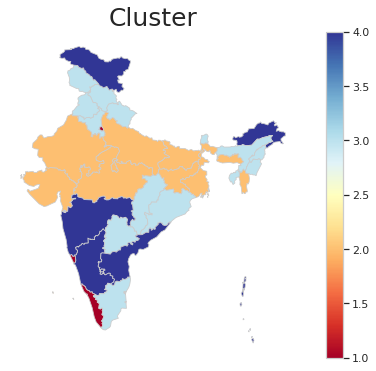

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Cluster', fontdict={'fontsize': '25', 'fontweight' : '3'})

# plot the figure
read_df.plot(column='Cluster_Code', cmap='RdYlBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,)

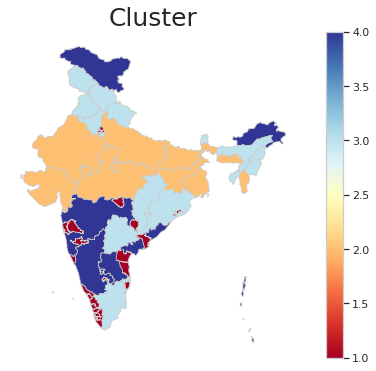

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Cluster', fontdict={'fontsize': '25', 'fontweight' : '3'})

# plot the figure
merged_df.plot(column='Cluster_Code', cmap='RdYlBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,)

In [ ]:
import pandas as pd
import numpy as np
import math

import geopandas as gpd
import json

from bokeh.io import output_notebook, show, output_file
output_notebook()
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select
from bokeh.layouts import widgetbox, row, column

In [ ]:
merged_json = json.loads(read_df.to_json())

#Convert to str like object
json_data = json.dumps(merged_json)
geosource = GeoJSONDataSource(geojson = json_data)


#Define a sequential multi-hue color palette.
# palette = brewer['RdYlGn'][8]
# #Reverse color order so that dark blue is highest obesity.
# palette = palette[::-1]
palette = ['red', 'purple', 'pink', 'yellow']
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = merged_df['Cluster_Code'].min(), high = merged_df['Cluster_Code'].max(), nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
# tick_labels = {'5000': '>5000'}

#Add hover tool
hover = HoverTool(tooltips = [ ('Name','@name'),('Cluster','@Cluster_Code')])
#Create color bar.
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
#Create figure object.
pp = figure(title = 'Number of Covid-19 cases', plot_height = 800 , plot_width = 850, toolbar_location = None, tools = [hover])
pp.xaxis.visible = False
pp.yaxis.visible = False
pp.xgrid.grid_line_color = None
pp.ygrid.grid_line_color = None
#Add patch renderer to figure.
pp.patches('xs','ys', source = geosource,fill_color = {'field' :'Cluster_Code', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify layout
pp.add_layout(color_bar, 'below')

output_file("foo.html")
#Display plot
show(pp)

In [ ]:
merged_json = json.loads(merged_df.to_json())

#Convert to str like object
json_data = json.dumps(merged_json)
geosource = GeoJSONDataSource(geojson = json_data)


#Define a sequential multi-hue color palette.
# palette = brewer['RdYlGn'][8]
# #Reverse color order so that dark blue is highest obesity.
# palette = palette[::-1]
palette = ['red', 'purple', 'pink', 'yellow']
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = merged_df['Cluster_Code'].min(), high = merged_df['Cluster_Code'].max(), nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
# tick_labels = {'5000': '>5000'}

#Add hover tool
hover = HoverTool(tooltips = [ ('Name','@name'),('Cluster','@Cluster_Code')])
#Create color bar.
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
#Create figure object.
pp = figure(title = 'Number of Covid-19 cases', plot_height = 800 , plot_width = 850, toolbar_location = None, tools = [hover])
pp.xaxis.visible = False
pp.yaxis.visible = False
pp.xgrid.grid_line_color = None
pp.ygrid.grid_line_color = None
#Add patch renderer to figure.
pp.patches('xs','ys', source = geosource,fill_color = {'field' :'Cluster_Code', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify layout
pp.add_layout(color_bar, 'below')

output_file("foo.html")
#Display plot
show(pp)

Not Working

In [ ]:
# !pip install -q bokeh==1.3.4

In [ ]:
# import bokeh.io
# bokeh.io.output_notebook()

In [ ]:
# import numpy as np

# import bokeh.io
# import bokeh.plotting
# import bokeh.transform
# import bokeh.util.hex

In [ ]:
# import json
# from bokeh.io import show
# from bokeh.io import output_file, save
# from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
#                           CustomJS, CustomJSFilter,
#                           GeoJSONDataSource, HoverTool,
#                           CategoricalColorMapper, LinearColorMapper, Slider)
# from bokeh.layouts import column, row, widgetbox
# from bokeh.io import output_notebook
# output_notebook()
# from bokeh.plotting import figure

In [ ]:
# geosource = GeoJSONDataSource(geojson = merged_df.to_json())

In [ ]:
# palette = ['red', 'purple', 'pink', 'green']

# color_mapper = CategoricalColorMapper(palette = palette, factors = ['1', '2', '3', '4'])

In [ ]:
# # Create figure object.
# p = figure(title = 'Red, Green and Orange Distric of Covid19: 31 May 2019',
#            plot_height = 700 ,
#            plot_width = 650,
#            toolbar_location = 'right',
#            tools = "pan, wheel_zoom, box_zoom, reset")
# p.title.text_font_size = '12pt'
# p.title.align = 'center'

# p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = None

# # Add patch renderer to figure.
# states = p.patches('xs','ys', source = geosource,
#                    fill_color = {'field' :'Zone',
#                                  'transform' : color_mapper},
#                    line_color = 'black',
#                    line_width = 0.25,
#                    fill_alpha = 1)
# # Create hover tool
# p.add_tools(HoverTool(renderers = [states],
#                       tooltips = [('Name','@name'),
#                                   ('Cluster','@Custer_Code')
#                                  ]))

# output_file('plot.html',mode='inline')
# save(p) # saves plot.html
# # bokeh.io.show(p)

In [ ]:
# show(p, notebook_handle = True)

In [ ]:
# show(p)